# Pre-Task: Prepare the CIFAR-10 data


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. It contains the below classes:

'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'.


Run the following cells in Pre-Task to set up packages and prepare the data.

In [ ]:
# Install tf-explain
!pip install -q tensorflow keras tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 455.7 kB/s eta 0:00:00


In [ ]:
# Import all libraries
import numpy as np
import tensorflow as tf
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
import keras
from keras.utils import to_categorical
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, MaxPool2D
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K
import matplotlib.pyplot as plt
import random
import os
import torch
import time
import warnings
warnings.filterwarnings('ignore')

Note that the default resources on COLAB are CPU-based, which will take a while to train. You can select "Runtime -> Change Runtime Type" to switch it to GPU, which goes much faster, but Google limits how much you can use such resources.

In [ ]:
# Define the number of epoch for each models vary these two parameters if you would like more/less training
trained_epoch = 10
untrain_epoch = 1
data_percentage = 0.3 # vary this parameter if you would like to use more/less of the data

# Percentage of data you want to work with
# Approximate time required to train both models,
# For 20% data: around 16 minutes
# For 30% data: around 24 minutes
# For 50% data: around 35 minutes
# For 70% data: around 45 minutes
# For 100% data: around 70 minutes

per_class = data_percentage/10

We want deterministic behavior for reproducibility (so we all see the same thing), so we need to be sure to seed the appropriate RNGs

In [ ]:
seed_value = 42
tf.random.set_seed(seed_value) # seed TensorFlow's RNG
np.random.seed(seed_value) # seed numPy's RNG
random.seed(seed_value) # seed Python's RNG
#tf.config.experimental.enable_op_determinism() # ensure the GPU uses deterministic operations

In [ ]:
# Load CIFAR-10 dataset
(x_train_large, y_train_large), (x_test_large, y_test_large) = cifar10.load_data()

# Define the number of samples you want to keep per class
training_samples_per_class = int(len(x_train_large)*per_class)

# Select equal number of samples from each class (for training)
train_selected_indices = []
for class_label in range(10):
    class_indices = tf.where(y_train_large == class_label)[:, 0]
    train_selected_indices.extend(class_indices[:training_samples_per_class])

# Define the number of samples you want to keep per class
testing_samples_per_class = int(len(x_test_large) * per_class)

# Select equal number of samples from each class (for testing)
test_selected_indices = []
for class_label in range(10):
    class_indices = tf.where(y_test_large == class_label)[:, 0]
    test_selected_indices.extend(class_indices[:testing_samples_per_class])

print(train_selected_indices)
print(test_selected_indices)

# Shuffle the indices
tf.random.set_seed(42)
train_selected_indices = tf.random.shuffle(train_selected_indices)
test_selected_indices = tf.random.shuffle(test_selected_indices)

print(train_selected_indices)
print(test_selected_indices)

# Use the selected indices to create the smaller dataset
x_train = x_train_large[train_selected_indices]
y_train = y_train_large[train_selected_indices]

x_test = x_test_large[test_selected_indices]
y_test = y_test_large[test_selected_indices]


# Define the labels of the dataset
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

170498071/170498071 [==============================] - 4s 0us/step
[<tf.Tensor: shape=(), dtype=int64, numpy=29>, <tf.Tensor: shape=(), dtype=int64, numpy=30>, <tf.Tensor: shape=(), dtype=int64, numpy=35>, <tf.Tensor: shape=(), dtype=int64, numpy=49>, <tf.Tensor: shape=(), dtype=int64, numpy=77>, <tf.Tensor: shape=(), dtype=int64, numpy=93>, <tf.Tensor: shape=(), dtype=int64, numpy=115>, <tf.Tensor: shape=(), dtype=int64, numpy=116>, <tf.Tensor: shape=(), dtype=int64, numpy=129>, <tf.Tensor: shape=(), dtype=int64, numpy=165>, <tf.Tensor: shape=(), dtype=int64, numpy=179>, <tf.Tensor: shape=(), dtype=int64, numpy=185>, <tf.Tensor: shape=(), dtype=int64, numpy=189>, <tf.Tensor: shape=(), dtype=int64, numpy=199>, <tf.Tensor: shape=(), dtype=int64, numpy=213>, <tf.Tensor: shape=(), dtype=int64, numpy=220>, <tf.Tensor: shape=(), dtype=int64, numpy=223>, <tf.Tensor: shape=(), dtype=int64, numpy=233>, <tf.Tensor: shape=(), dtype=int64, numpy=264>, <tf.Tensor: shape=(), dtype=int64, numpy=276>

Now we are done loading data, let's look at it!

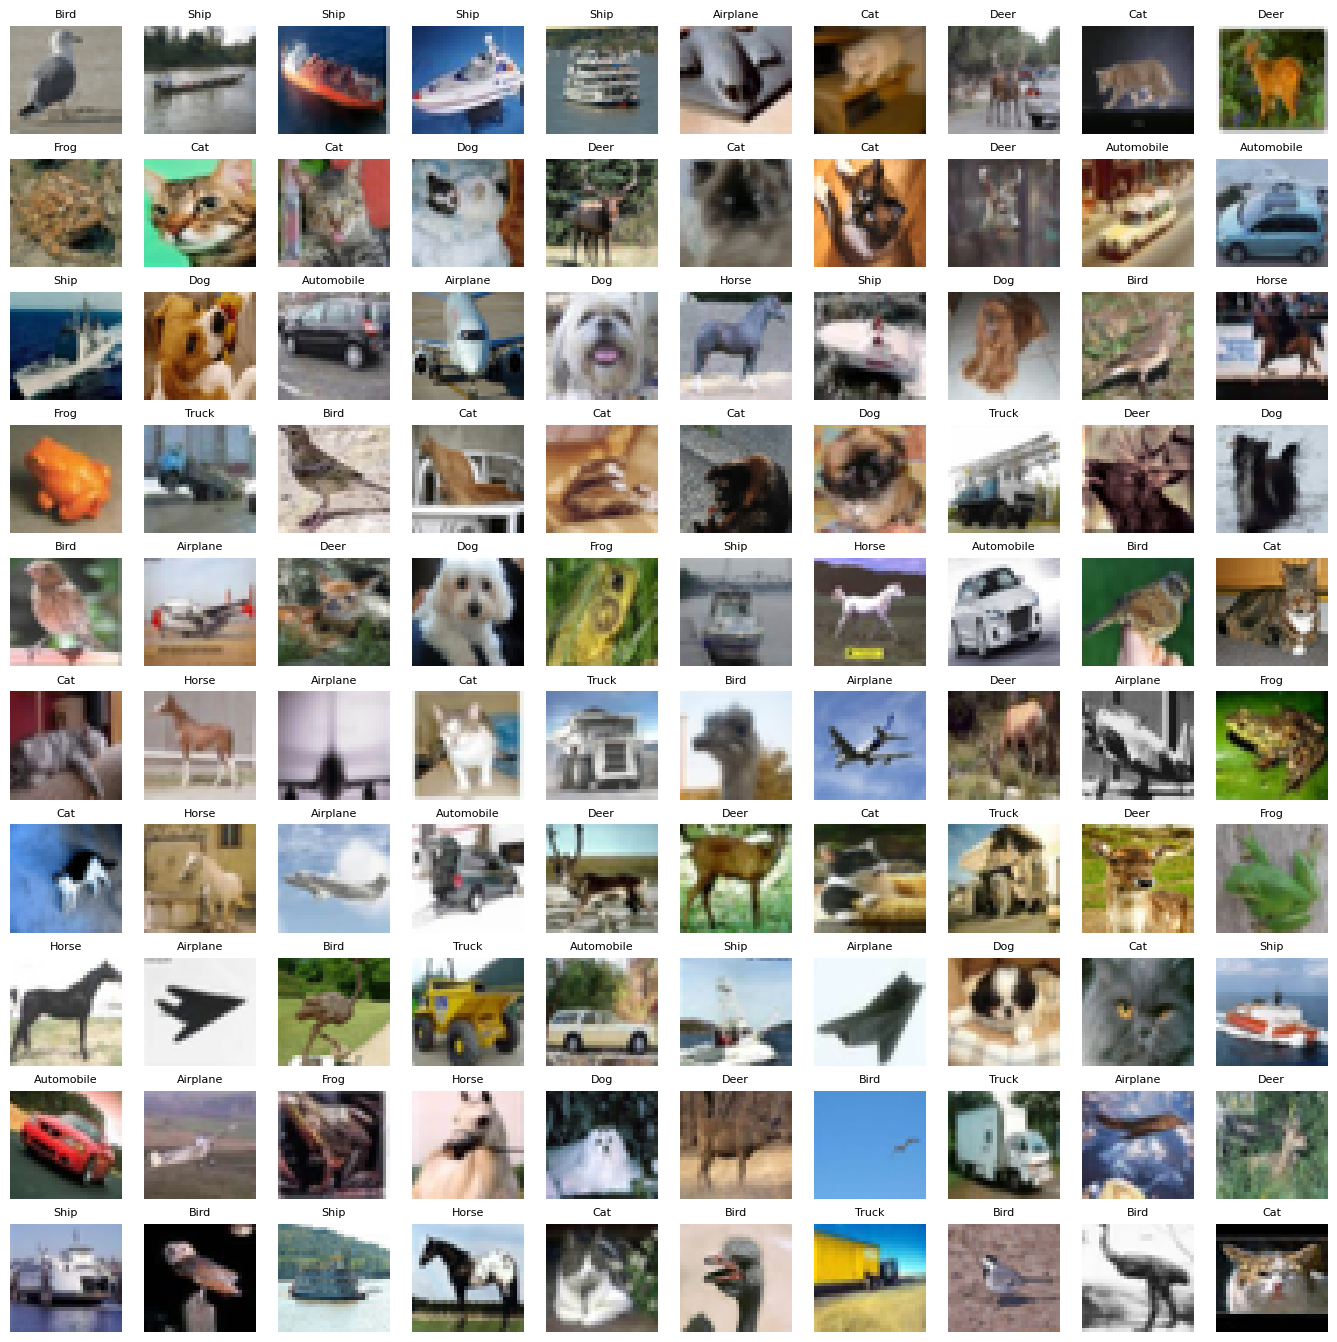

In [ ]:
# Define the dimensions of the plot grid to view more images in that grid format
W_grid = 10
L_grid = 10

# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(x_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index
    axes[i].imshow(x_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.2)

Preprocessing to convert images using integer pixel values (0-255) to using float pixel values (0-1).


In [ ]:
X_train = x_train.astype('float32') / 255.0
X_test = x_test.astype('float32') / 255.0
# map strings to numbers (i.e., "ship" class becomes "5", or similar)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Number of training samples: ", len(X_train))
print("Number of testing samples: ", len(X_test))

Number of training samples:  15000
Number of testing samples:  3000


Next, define several functions which will help us in the future

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    return im, cbar

In [ ]:
def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > threshold else "black")
            texts.append(text)

    return texts

In [ ]:
def performance(model):
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("Accuracy: %.2f%%" % (scores[1]*100))

  Y_pred_classes = np.argmax(model.predict(X_test), axis=1)
  print("Classification Report:")
  print(classification_report(np.argmax(y_test, axis=1), Y_pred_classes))

  # Convert validation observations to one hot vectors
  Y_true = np.argmax(y_test, axis=1)
  # Errors are difference between predicted labels and true labels
  errors = (Y_pred_classes - Y_true != 0)

  Y_pred_classes_errors = Y_pred_classes[errors]
  Y_pred_errors = Y_pred_classes[errors]
  Y_true_errors = Y_true[errors]
  X_test_errors = X_test[errors]

  cm = confusion_matrix(Y_true, Y_pred_classes)
  thresh = cm.max() / 2.

  fig, ax = plt.subplots(figsize=(12,8))
  im, cbar = heatmap(cm, labels, labels, ax=ax,
                    cmap=plt.cm.Blues, cbarlabel="count of predictions")
  texts = annotate_heatmap(im, data=cm, threshold=thresh)

  fig.tight_layout()
  plt.show()

  return Y_true, Y_pred_classes

# Task 1: Build a Well-Trained Model for the classification

A. [**Team, TURN THIS IN**] How well do you think this model is performing based on the classification report and confusion matrix?

B. [**Team, TURN THIS IN**] Which class was classified most accurately?

C. [**Team, TURN THIS IN**] Which class was classified least accurately?

D. [**Team, TURN THIS IN**] Which confusion was the most common?

E. [**Each, TURN THIS IN**] Using the classification report and confusion matrix, identify a prevalent error where a class where the predicted label is significantly dissimilar or nonsensical compared to the true label (i.e., not cat and dog, since they have a similar morphology as a 4-legged mammal).

In [ ]:
INPUT_SHAPE = X_train.shape[1:]
KERNEL_SIZE = (3, 3)

Next we define a function to create a neural network to be our larger model (this is the one we will define as "trained", because we will be training it for more epochs)

In [ ]:
def create_larger_model(INPUT_SHAPE,KERNEL_SIZE):
  model = Sequential()

  # Convolutional Layer
  model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
  model.add(BatchNormalization())
  # Pooling layer
  model.add(MaxPool2D(pool_size=(2, 2)))
  # Dropout layers
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  # model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))

  return model

Now, actually create and train that NN. Then print out a classification report and confusion matrix

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

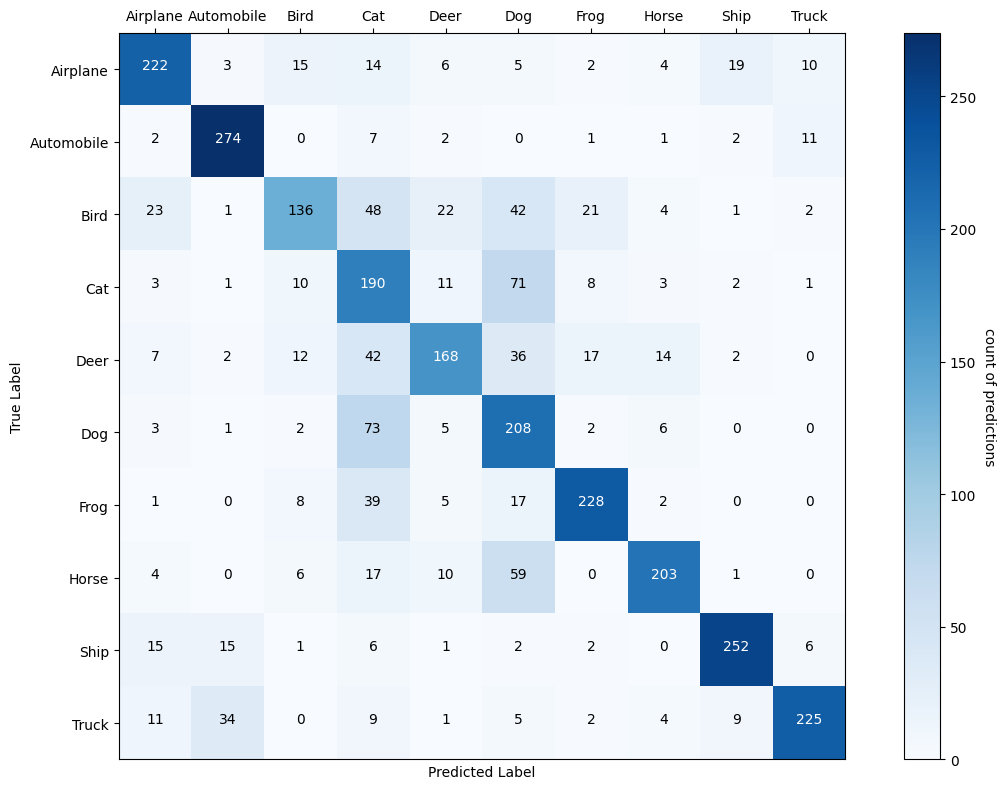

In [ ]:
start = time.time()
trained_model = create_larger_model(INPUT_SHAPE,KERNEL_SIZE)
trained_model.summary()
trained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
trained_model.fit(X_train, y_train, batch_size=64, epochs=trained_epoch, validation_data=(X_test, y_test))

trained_true, trained_predict = performance(trained_model)

In [ ]:
end = time.time()
print("Total training time (seconds): ", end - start)

Total training time (seconds):  1309.1205604076385


# Task 2: Build an under-trained Model for classification

A. [**Team, TURN THIS IN**] How well do you think this model is performing based on the classification report and confusion matrix?

B. [**Team, TURN THIS IN**] Which class was classified most accurately?

C. [**Team, TURN THIS IN**] Which class was classified least accurately?

D. [**Team, TURN THIS IN**] Which confusion was the most common?

E. [**Each, TURN THIS IN**] Using the classification report and confusion matrix, identify a prevalent error where a class where the predicted label is significantly dissimilar or nonsensical compared to the true label (i.e., not cat and dog, since they have a similar morphology as a 4-legged mammal).

F. [**Each, TURN THIS IN**] Compare the prevalent errors of this model with the prevalent errors of the previous one.

G. [**Team, TURN THIS IN**] Compare the runtime of training this model with the previous one.

As before, define a function to create a NN

In [ ]:
def create_smaller_model(INPUT_SHAPE,KERNEL_SIZE):

  model2 = Sequential()
  model2.add(Conv2D(32, KERNEL_SIZE, activation='relu', input_shape=INPUT_SHAPE))
  model2.add(MaxPooling2D(pool_size=(2, 2)))
  model2.add(Conv2D(64, KERNEL_SIZE, activation='relu'))
  model2.add(MaxPooling2D(pool_size=(2, 2)))
  model2.add(Flatten())
  model2.add(Dense(32, activation='relu'))
  model2.add(Dense(10, activation='softmax'))

  return model2

And again as before, actually create the NN, train, and produce output

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 32)               

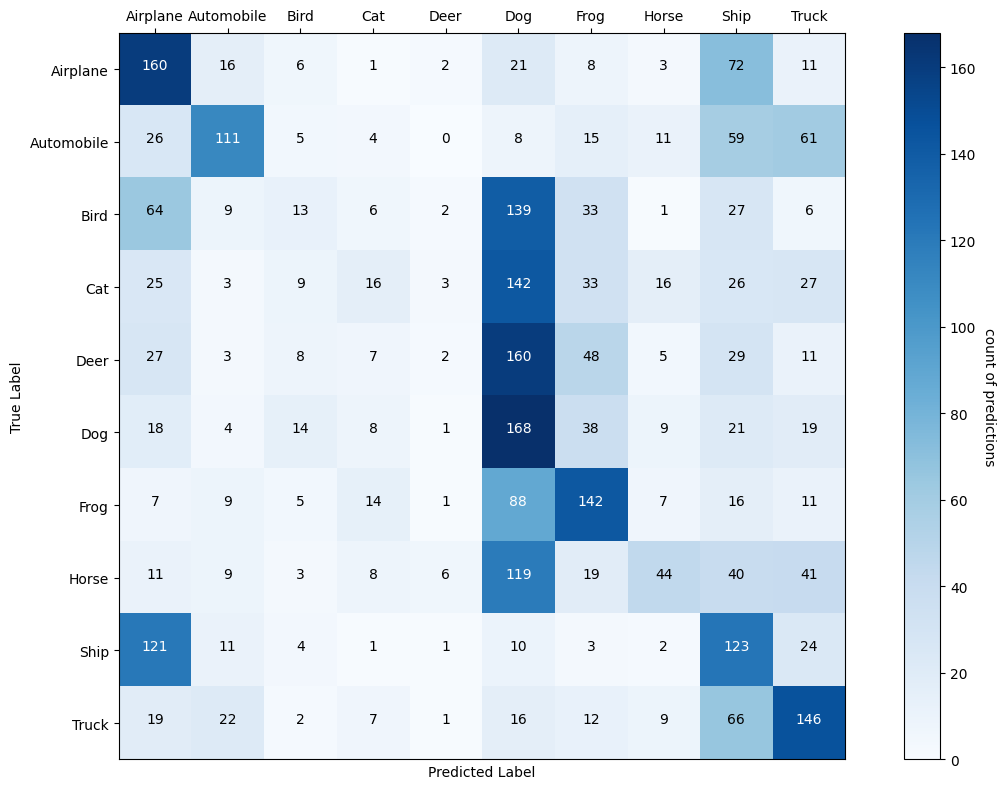

In [ ]:
start = time.time()
untrained_model = create_smaller_model(INPUT_SHAPE, KERNEL_SIZE)
untrained_model.summary()
untrained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
untrained_model.fit(X_train, y_train, batch_size=256, epochs=untrain_epoch, validation_data=(X_test, y_test))
untrained_true, untrained_predict = performance(untrained_model)

In [ ]:
end = time.time()
print("Total training time (seconds): ", end - start)

Total training time (seconds):  22.87356424331665


# Task 3: Analyze Gradient-based Saliency Map Explanations

A. [**Each, TURN THIS IN**] Find one more index where the trained model performed better than the under-trained model in the gradient-based saliency map. Include both the index and an image of the saliency map in your submission.

B. [**Each, TURN THIS IN**] Find one more index where the under-trained model performed better than the trained model in gradient-based saliency map. Include both the index and an image of the saliency map in your submission.

C. [**Each, TURN THIS IN**] Find one more index where the trained and under-trained models both produced a sensible saliency map. Include both the index and an image of the saliency map in your submission.

Again, define some helper functions, this time for computing saliency maps and plotting them side-by-side with the original image.

In [ ]:
def plot_saliency_map(sample_image, saliency_map):
  plt.figure(figsize=(4, 2))
  plt.subplot(1, 2, 1)
  plt.title("Original Image")
  plt.imshow(sample_image.squeeze())

  plt.subplot(1, 2, 2)
  plt.title("Saliency Map")
  plt.imshow(saliency_map)
  plt.colorbar()

  plt.show()

In [ ]:
def gradient_salency_map(model, sample_index):

  sample_image = x_test[sample_index][np.newaxis]
  #sample_image = x_test[sample_index]
  sample_label = y_test[sample_index]
  sample_class_index = np.argmax(sample_label)

  # Initialize GradCAM object
  explainer = GradCAM()
  # Explain the model predictions on the sample image
  saliency_map = explainer.explain((sample_image, None), model, class_index=sample_class_index)

  plot_saliency_map(sample_image, saliency_map)

Create a bunch of sets we can use to evaluate the explanations.
* trained_better = Indexes where the trained model performed better
* untrained_better = Indexes where the untrained model performed better
* both_good = Indexes where both models performed well

In [ ]:
#Index where the trained model performed better
trained_better = [1358, 1226, 1235, 1654, 1913]

#Index where the untrained model performed better
untrained_better = [1324, 1069, 1297, 1573, 1606]

#Index where the both performed better
both_good = [1097, 1921, 2080]

# Test set for you to vary when finding indices
investigate = list(range(2, 7)) # vary this parameter to see different images

Next, we combine ingredients to compute and view our saliency maps!

Index: 1358


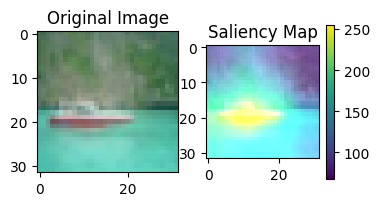

Actural Class of the trained model: Ship
Predicted Class of the trained model:: Ship


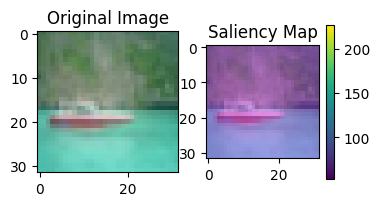

Actual Class of the under-trained model:: Ship
Predicted Class of the under-trained model:: Bird
-------------------------------------------------------------------------------------------------------------------------------------------
Index: 1226


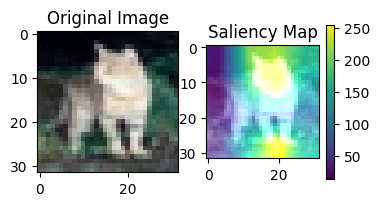

Actural Class of the trained model: Cat
Predicted Class of the trained model:: Cat


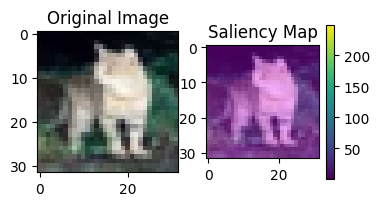

Actual Class of the under-trained model:: Cat
Predicted Class of the under-trained model:: Dog
-------------------------------------------------------------------------------------------------------------------------------------------
Index: 1235


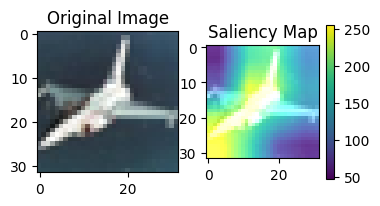

Actural Class of the trained model: Airplane
Predicted Class of the trained model:: Airplane


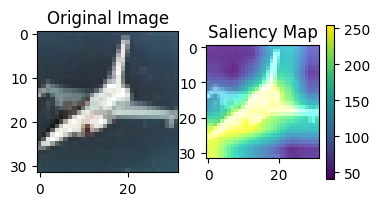

Actual Class of the under-trained model:: Airplane
Predicted Class of the under-trained model:: Ship
-------------------------------------------------------------------------------------------------------------------------------------------
Index: 1654


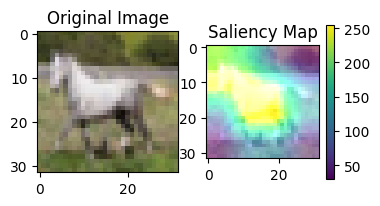

Actural Class of the trained model: Horse
Predicted Class of the trained model:: Horse


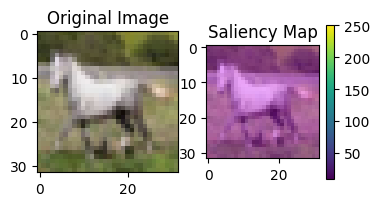

Actual Class of the under-trained model:: Horse
Predicted Class of the under-trained model:: Dog
-------------------------------------------------------------------------------------------------------------------------------------------
Index: 1913


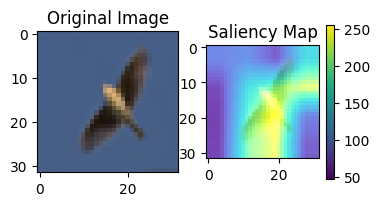

Actural Class of the trained model: Bird
Predicted Class of the trained model:: Bird


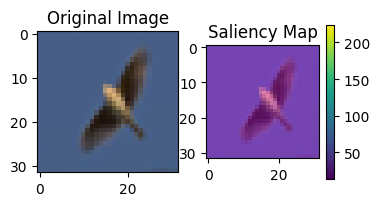

Actual Class of the under-trained model:: Bird
Predicted Class of the under-trained model:: Airplane
-------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Change this for the remaining two sets
index_lst = trained_better

for index in index_lst:
  print("Index:", index)

  gradient_salency_map(trained_model, index)
  print("Actural Class of the trained model:", labels[trained_true[index]])
  print("Predicted Class of the trained model::", labels[trained_predict[index]])

  gradient_salency_map(untrained_model, index)
  print("Actual Class of the under-trained model::", labels[untrained_true[index]])
  print("Predicted Class of the under-trained model::", labels[untrained_predict[index]])
  print('-------------------------------------------------------------------------------------------------------------------------------------------')


# Task 4: Analyze Perturbation-based Saliency Map Explanations

A. [**Each, TURN THIS IN**] Find one more index where the trained model performed better than the under-trained model in the perturbation-based saliency map. Include both the index and an image of the saliency map in your submission.

B. [**Each, TURN THIS IN**] Find one more index where the under-trained model performed better than the trained model in perturbation-based saliency map. Include both the index and an image of the saliency map in your submission.

C. [**Each, TURN THIS IN**] Find one more index where the trained and under-trained models both produced a sensible saliency map. Include both the index and an image of the saliency map in your submission.

As before, create a helper function to generate these saliency maps, generate sets of lists, and combine ingredients

In [ ]:
def perturbation_saliency_map(model, sample_index):
  sample_image = x_test[sample_index][np.newaxis]
  sample_label = y_test[sample_index]
  sample_class_index = np.argmax(sample_label)

  # Initialize Occlusion Sensitivity object
  explainer = OcclusionSensitivity()
  # Explain the model predictions on the sample image
  grid = explainer.explain((sample_image, None), model, class_index=sample_class_index,patch_size=3)

  # Normalize the saliency map
  saliency_map = grid / np.max(grid)

  plot_saliency_map(sample_image, saliency_map)

In [ ]:
#Index where the trained model performed better
trained_better = [1363, 1312, 1501, 2180, 2969]

#Index where the untrained model performed better
untrained_better = [1289, 1173, 1481, 1236]

#Index where the both performed better
both_good = [1694]

# Test set for you to vary when finding indices
investigate = list(range(2, 7)) # vary this parameter to see different images

Index: 1363
4/4 [==============================] - 0s 64ms/step


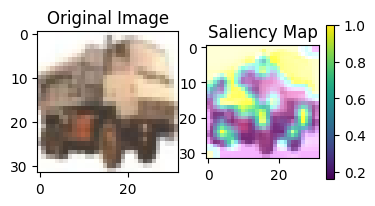

Actural Class of the trained model: Truck
Predicted Class of the trained model:: Truck
4/4 [==============================] - 0s 11ms/step


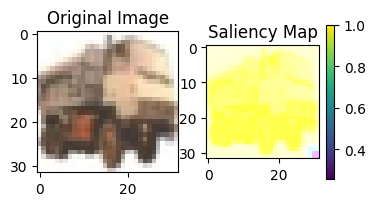

Actual Class of the under-trained model:: Truck
Predicted Class of the under-trained model:: Truck
-------------------------------------------------------------------------------------------------------------------------------------------
Index: 1312
4/4 [==============================] - 0s 58ms/step


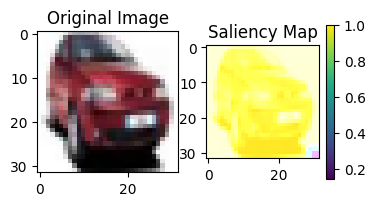

Actural Class of the trained model: Automobile
Predicted Class of the trained model:: Automobile
4/4 [==============================] - 0s 12ms/step


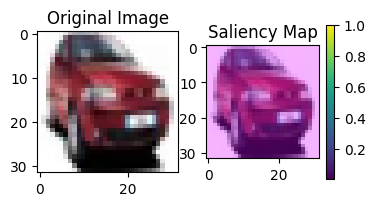

Actual Class of the under-trained model:: Automobile
Predicted Class of the under-trained model:: Truck
-------------------------------------------------------------------------------------------------------------------------------------------
Index: 1501
4/4 [==============================] - 0s 57ms/step


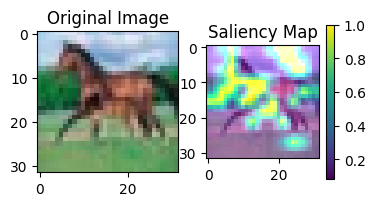

Actural Class of the trained model: Horse
Predicted Class of the trained model:: Horse
4/4 [==============================] - 0s 12ms/step


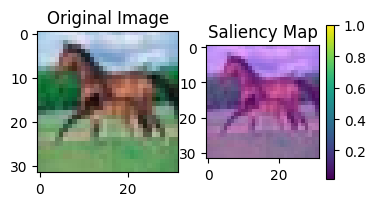

Actual Class of the under-trained model:: Horse
Predicted Class of the under-trained model:: Truck
-------------------------------------------------------------------------------------------------------------------------------------------
Index: 2180
4/4 [==============================] - 0s 59ms/step


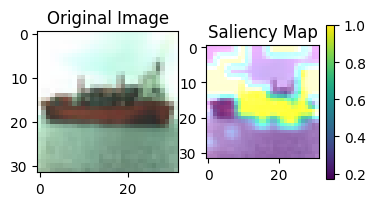

Actural Class of the trained model: Ship
Predicted Class of the trained model:: Ship
4/4 [==============================] - 0s 19ms/step


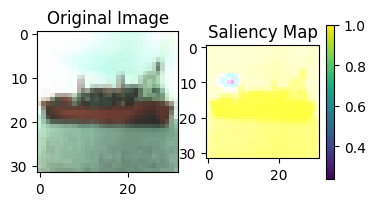

Actual Class of the under-trained model:: Ship
Predicted Class of the under-trained model:: Airplane
-------------------------------------------------------------------------------------------------------------------------------------------
Index: 2969
4/4 [==============================] - 0s 105ms/step


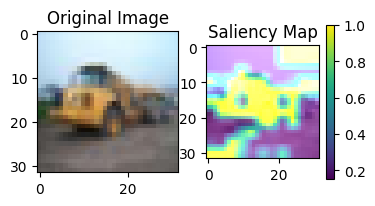

Actural Class of the trained model: Truck
Predicted Class of the trained model:: Truck
4/4 [==============================] - 0s 22ms/step


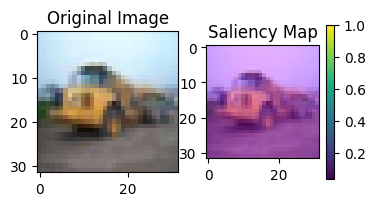

Actual Class of the under-trained model:: Truck
Predicted Class of the under-trained model:: Ship
-------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# vary this parameter
index_lst = trained_better

for index in index_lst:
  print("Index:", index)

  perturbation_saliency_map(trained_model, index)
  print("Actural Class of the trained model:", labels[trained_true[index]])
  print("Predicted Class of the trained model::", labels[trained_predict[index]])

  perturbation_saliency_map(untrained_model, index)
  print("Actual Class of the under-trained model::", labels[untrained_true[index]])
  print("Predicted Class of the under-trained model::", labels[untrained_predict[index]])

  print('-------------------------------------------------------------------------------------------------------------------------------------------')

# Task 5: Big Picture

A. [**Team, TURN THIS IN**] Compare and contrast the explanation output of Gradient-based vs Perturbation-based saliency map. You may find it helpful to consult section 2 of this paper to understand the difference between these two saliency techniques: http://proceedings.mlr.press/v80/greydanus18a.html

B. [**Team, TURN THIS IN**] Consider figure 2 from this paper: https://arxiv.org/abs/1810.03292 It shows the output of a variety of saliency techniques based on a single input image while randomizing parameters of the NN. Essentially, the figure shows that some techniques are explaining the MODEL more and others are explaining the DATA more. Name one gradient generation strategy that falls into each category